In [77]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
code_root = project_root / "gbi_diff"
sys.path.extend([str(project_root), str(code_root)])
print(sys.path)

['/home/robin/miniconda3/envs/gbi/lib/python312.zip', '/home/robin/miniconda3/envs/gbi/lib/python3.12', '/home/robin/miniconda3/envs/gbi/lib/python3.12/lib-dynload', '', '/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages', '/home/robin/projects/lab_project/neuralgbi_diffusion', '/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_diff', '/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/setuptools/_vendor', '/tmp/tmpmeynty4h', '/home/robin/projects/lab_project/neuralgbi_diffusion', '/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_diff', '/home/robin/projects/lab_project/neuralgbi_diffusion', '/home/robin/projects/lab_project/neuralgbi_diffusion/gbi_diff']


In [78]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
from tqdm import tqdm

from gbi_diff.model.lit_module import (DiffusionModel, Guidance,
                                       PotentialNetwork)
from gbi_diff.sampling.utils import get_sample_path, load_observed_data
from gbi_diff.utils.criterion import SBICriterion
from gbi_diff.utils.plot import _pair_plot
from gbi_diff.utils.sampling_diffusion_config import Config
from gbi_diff.utils.train_diffusion_config import Config as DiffusionConfig
from gbi_diff.utils.train_guidance_config import Config as GuidanceConfig

In [112]:
guidance_ckpt = str(project_root) +  "/results/guidance/two_moons/lightning_logs/version_0/epoch=94-step=3800.ckpt"
guidance_ckpt = str(project_root) +  "/results/guidance/two_moons/lightning_logs/version_6/epoch=59-step=2400.ckpt"
guidance_ckpt = str(project_root) +  "/results/guidance/two_moons/lightning_logs/version_12/epoch=84-step=3400.ckpt"
guidance_model = Guidance.load_from_checkpoint(guidance_ckpt)
observed_data_file = project_root.joinpath("data","two_moons_10000.pt") 
x_o, theta = load_observed_data(observed_data_file)

Text(0.5, 0.98, 'Likelihood estimate vs gt: T=0, idx=6')

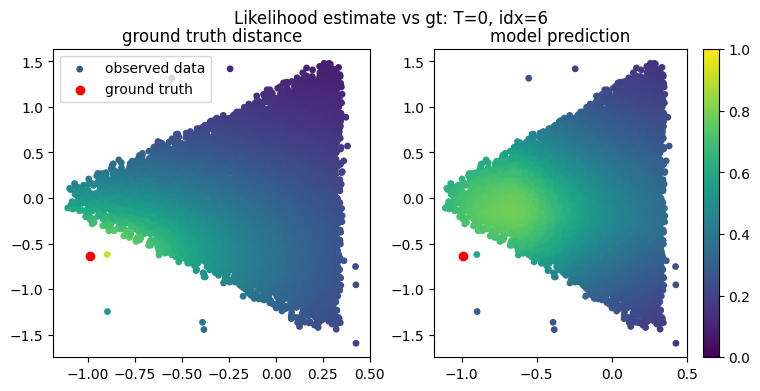

In [121]:
idx = 6
T = 0
time_repr = guidance_model.get_diff_time_repr(np.ones(1) * T)
likelihood = guidance_model.forward(theta[[idx]], x_o[None], time_repr).detach().numpy()
likelihood = np.exp(-likelihood[0, :, 0])
criterion = SBICriterion()
ground_truth_distance = criterion.sample_distance(x_o[[idx]], x_o[None])
gt_likelihood = np.exp(-ground_truth_distance[0])

fig, axs = plt.subplots(ncols=2, figsize=(9, 4))

mapable = axs[0].scatter(*x_o.detach().numpy().T, c=gt_likelihood, s=15, label="observed data", vmin=0, vmax=1)
axs[0].scatter(*x_o[idx], c="r", label="ground truth")
axs[0].set_title("ground truth distance")
axs[0].legend()

mapable = axs[1].scatter(*x_o.detach().numpy().T, c=likelihood, s=15, label="observed data",  vmin=0, vmax=1)
axs[1].scatter(*x_o[idx], c="r", label="ground truth")
axs[1].set_title("model prediction")


fig.colorbar(mapable)
fig.suptitle(f"Likelihood estimate vs gt: T={T}, idx={idx}")

Text(0.5, 0.98, 'Likelihood estimate vs gt: T=0, idx=3')

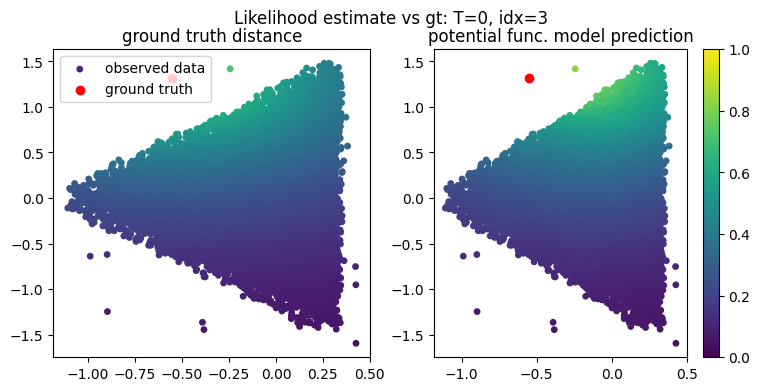

In [ ]:
idx = 3         
T = 0
ckpt = project_root.joinpath("results", "gbi", "two_moons", "lightning_logs", "version_71", "epoch=94-step=3800.ckpt")
potential_function = PotentialNetwork.load_from_checkpoint(ckpt)
likelihood = potential_function.forward(x_o[[idx]], x_o[None]).detach().numpy()
likelihood = np.exp(-likelihood[0, :, 0])
criterion = SBICriterion()
ground_truth_distance = criterion.sample_distance(x_o[[idx]], x_o[None])
gt_likelihood = np.exp(-ground_truth_distance[0])

fig, axs = plt.subplots(ncols=2, figsize=(9, 4))

mapable = axs[0].scatter(*x_o.detach().numpy().T, c=gt_likelihood, s=15, label="observed data", vmin=0, vmax=1)
axs[0].scatter(*x_o[idx], c="r", label="ground truth")
axs[0].set_title("ground truth distance")
axs[0].legend()

mapable = axs[1].scatter(*x_o.detach().numpy().T, c=likelihood, s=15, label="observed data",  vmin=0, vmax=1)
axs[1].scatter(*x_o[idx], c="r", label="ground truth")
axs[1].set_title("potential func. model prediction")


fig.colorbar(mapable)
fig.suptitle(f"Likelihood estimate vs gt: T={T}, idx={idx}")